In [1]:

%pylab inline

import tensorflow as tf
%matplotlib inline
import numpy as np
from collections import deque
from os import listdir
import functools


import pylab
from tsne import bh_sne
from matplotlib import pyplot as plt
import pandas
import scipy
import numpy as np
import sklearn.manifold
import os
import gc
from time import gmtime, strftime
import seaborn as sns
from os import listdir
from os.path import isfile, join
import math
from scipy.stats.stats import pearsonr
import random as rand
import pyproj
import functools
import pickle
import random
%autosave 30

image_width = 128

def display(image, min = 0.0, max = 1.0):
    plt.imshow(image, cmap = plt.get_cmap('gray'), interpolation='nearest')
    plt.show()
    
    
def memoize(obj, maxlen = 2000):
    """A decorator to cache advice objects using the advice key"""
    cache = obj.cache = {}
    deck = obj.deck = deque([], maxlen = maxlen)

    @functools.wraps(obj)
    def memoizer(*args, **kwargs):
        key = args[0]
        if key not in cache:
            if len(deck) == deck.maxlen:
              del cache[deck.popleft()[0]]
            temp = obj(*args, **kwargs)
            cache[key] = temp
            deck.append((key, temp))
        return cache[key]
        
    return memoizer

@memoize
def load_mat_from_file(key):
    f = file("/home/isaac/Desktop/devika/ARCGIS/ArcGis/pickle_files/"+key+".npy","rb")
    return np.load(f)

@memoize
def get_file_containing(housex, housey):
#         print "house coords:", housex, housey
    for key in file_attributes:
        block = file_attributes[key]
    #         print block['xllcorner'], block['yllcorner']
        if block['xllcorner'] < housex < block['xllcorner'] + block['width']:
            if block['yllcorner'] < housey < block['yllcorner'] + block['height']:
                return key
    assert(1==0)

def imagex(housex, housey, block):
    return (int(housex)-block['xllcorner'])/5
def imagey(housex, housey, block):
    return (int(housey)-block['yllcorner'])/5



#housex and housey in meters
def get_heightmap_around(housex, housey, window_width_pixels = 28):
    
    def image_slice(key, housex, housey, radius = window_width_pixels/2):
        x = housex
        y = housey
        block = file_attributes[key]
        mat = load_mat_from_file(key)
        x1 = np.max([0,              imagex(x,y,block) - radius])
        x2 = np.min([block['ncols'], imagex(x,y,block) + radius])
        
        y1 = np.max([0,              imagey(x,y,block) - radius])
        y2 = np.min([block['nrows'], imagey(x,y,block) + radius])
        
        assert(x1 <= x2)
        assert(y1 <= y2)
        return  mat[block['nrows'] - y2:block['nrows'] - y1, x1:x2]
    
    window_width_feet = window_width_pixels * 5
    housex /= .3048 #convert to feet
    housey /= .3048
    x = housex
    y = housey
    ul = get_file_containing(x - window_width_feet/2, y - window_width_feet/2)
    ur = get_file_containing(x + window_width_feet/2, y - window_width_feet/2)
    ll = get_file_containing(x - window_width_feet/2, y + window_width_feet/2)
    lr = get_file_containing(x + window_width_feet/2, y + window_width_feet/2)

    for key in [ul, ur, ll, lr]:
        image = image_slice(key, x, y)
#         print image.shape
        if image.shape == (window_width_pixels, window_width_pixels):
            return image

    

    if ul == ur and lr == ll : # horizontal split


        result = np.zeros([window_width_pixels, window_width_pixels])
        upper_slice = image_slice(ul, housex, housey)
        lower_slice = image_slice(ll, housex, housey)
        
        result[:upper_slice.shape[0], :] = upper_slice
        result[ window_width_pixels - lower_slice.shape[0]:, :] = lower_slice


        return result
    elif ul == ll and ur == lr and ul != ur and ll != lr: # vertical split
        result = np.zeros([window_width_pixels, window_width_pixels])
        left_slice = image_slice(ll, housex, housey)
        right_slice = image_slice(ur, housex, housey)
#         print left_slice.shape
#         print right_slice.shape
        
        result[:, :left_slice.shape[1]] = left_slice
        result[:, window_width_pixels - right_slice.shape[1]:] = right_slice

#         plt.imshow(result)
#         plt.show()
#         display(result)

        return result
    else: # four way split
#         print "four way"
        ll_slice = image_slice(ll, housex, housey)
        ul_slice = image_slice(ul, housex, housey)
        lr_slice = image_slice(lr, housex, housey)
        ur_slice = image_slice(ur, housex, housey)
        
        result = np.zeros([window_width_pixels, window_width_pixels])
        result[:ll_slice.shape[0], :ll_slice.shape[1]] = ll_slice
        result[:lr_slice.shape[0], window_width_pixels - lr_slice.shape[1]:] = lr_slice
        
        result[window_width_pixels - ul_slice.shape[0]:, :ul_slice.shape[1]] = ul_slice
        result[window_width_pixels - ur_slice.shape[0]:, window_width_pixels - ur_slice.shape[1]:] = ur_slice
#         display(result)
        return result

        

def window_violated_chunk_borders(housex, housey):
    corners = [(housex-window_width_feet/2, housey-window_width_feet/2),
              (housex-window_width_feet/2, housey+window_width_feet/2),
              (housex+window_width_feet/2, housey+window_width_feet/2),
              (housex+window_width_feet/2, housey-window_width_feet/2)]
    files = map(lambda x: get_file_containing(x[0], x[1]), corners)
    return len(set(files)) > 1



file_attributes = {}

mypath = "/home/isaac/Desktop/devika/ARCGIS/ArcGis/ascii_files"
for filename in [f for f in listdir(mypath) if isfile(join(mypath, f))]: 
    attributes = {}
    with open(mypath + "/" + filename) as FileObj:
        for index, line in enumerate(FileObj):
            if(index < 6):
#                 print line
                attributes[line.split(" ")[0]] = int(line.split(" ")[-1][:-2])
            else:
                break # don't load the other lines into memory becuase that's a waste of time.

    attributes['width'] = attributes['ncols'] * attributes['cellsize']
    attributes['height'] = attributes['nrows'] * attributes['cellsize']
    file_attributes[filename] = attributes
print "loaded all file header attributes into dict"


def load_data(path, normalize_columns = False, only_columns_containing = ""):
    print("loading...")
    gc.collect() # collect garbage
    data = pandas.read_hdf(path, '/df')
    df = pandas.DataFrame(data)
    df = df.sort(['hcad']).fillna(0)
    df = df.reset_index()#(ascending=True)

    data_dict = {}
    for label in set(df._get_numeric_data().columns).union({'hcad'}):
        # union hcad to ensure that hcad col comes in even if not considered numerical
        if normalize_columns and  label != 'hcad':
            column_data = np.array(df[label].astype(float))
            column_data -= np.min(column_data)
            data_dict[label] = column_data / np.max(column_data)
        elif label != 'hcad':
            data_dict[label] = df[label].astype(float)

    result = pandas.DataFrame.from_dict(data_dict)

    result = result.replace([np.inf, -np.inf], 1)
    
    
    for label in result:
        if not only_columns_containing in str(label):
            result.drop([str(label)], axis = 1 , inplace= True)

    return result


wind_data = load_data("/home/isaac/Dropbox/data_for_brian/wind_features/hcad_interp_withoutpartial_rad100_hist8x8.mat.hd", 
              normalize_columns=True, only_columns_containing = "spd")
meta = load_data("/home/isaac/Dropbox/data_for_brian/meta/df_meta.hd")
y_data = load_data("/home/isaac/Dropbox/data_for_brian/y_df.hd")
hcad = load_data("/home/isaac/Dropbox/data_for_brian/hcad_features/hcad_df_point.hd", 
              normalize_columns=True)
# wind_data = wind_data[meta['img0'] == 1]
# y_data = wind_data[meta['img0'] == 1]
y_gaussian = pickle.load(open( "/home/isaac/Desktop/house_guassian_damage_balance.p", "rb" ) )

wgs84=pyproj.Proj("+init=EPSG:4326") # LatLon with WGS84 datum used by GPS units and Google Earth
UTM26N=pyproj.Proj("+init=EPSG:2278") # UTM coords, zone Texas Central, WGS84 datum



# metamat, extra_features, regression_y, cat_y = get_batch(1, random = False, start_index=12314)

# meta = load_data("/home/isaac/Dropbox/data_for_brian/meta/df_meta.hd")

# X, _, _ = get_batch(100)
# plt.imshow(X[0,:,:,0])
# plt.show()
# X = X[:,:,:,0].reshape([-1])
# print np.min(X)
# plt.hist(X, bins = 50)
# plt.show()
hcad = np.array(hcad)
wind_data = np.array(wind_data)


# convert hcad to nice log scale
for i in range(hcad.shape[1]):
    hcad[:,i] = log(hcad[:,i] + .001)
    hcad[:,i] -= np.min(hcad[:,i])
    hcad[:,i] /= np.max(hcad[:,i])

housewise_square_damage_actual = np.array(pickle.load( open( "../housewise_square_damage_actual.p", "rb" ) ))


Populating the interactive namespace from numpy and matplotlib


Autosaving every 30 seconds
loaded all file header attributes into dict
loading...
Opening /home/isaac/Dropbox/data_for_brian/wind_features/hcad_interp_withoutpartial_rad100_hist8x8.mat.hd in read-only mode
loading...
Opening /home/isaac/Dropbox/data_for_brian/meta/df_meta.hd in read-only mode
loading...
Opening /home/isaac/Dropbox/data_for_brian/y_df.hd in read-only mode
loading...
Opening /home/isaac/Dropbox/data_for_brian/hcad_features/hcad_df_point.hd in read-only mode


In [2]:
image_width = 224

def get_batch(batch_size = 100, randomize = True, start_index = 0, end_index = len(meta)-1, val = False):
    metamat = np.zeros([batch_size, image_width, image_width, 3]).astype(float32)
    regression_y = np.zeros([batch_size]).astype(float32)
    categorical_y = np.zeros([batch_size]).astype(int32)
    extra_features = np.zeros([batch_size, wind_data.shape[1] + hcad.shape[1]]).astype(float32)
    i = 0
    while i < batch_size:

        index = (i + start_index)
        if randomize:
            index = rand.randint(0, len(meta)-1) % end_index
            if index % 100 == 0 and not val:
                index +=  rand.randint(1, 99)
                if index > len(meta):
                    index = len(meta) -1
            elif val:
                index -= index % 100
        lon = [meta['lon'][index]]
        lat = [meta['lat'][index]]
        max_wind_speed = np.max(wind_data[index])
        regression_y[i] = housewise_square_damage_actual[index]
        categorical_y[i] = y_data['y'][index]
#         print (categorical_y[i])
        if random.random() < .725 and categorical_y[i] == 0:
#         if categorical_y[i] == 0:
            continue
#         print hcad[index].shape
#         print wind_data[index].shape
        extra_features[i] = np.concatenate([wind_data[index], hcad[index]], axis = 0)

        xx, yy = pyproj.transform(wgs84, UTM26N, lon, lat)
        housex=xx[0]
        housey=yy[0]

        lidar = None
        try:
            lidar = get_heightmap_around(housex, housey, window_width_pixels=image_width)
        except:
#             print "oops pham"
            continue
        if(lidar == None):
            continue
        
        lidar = lidar.copy()
#         print lidar
#         plt.imshow(lidar)
#         plt.show()
        lidar = (lidar - np.mean(lidar)) / 50.0 #/ np.std(lidar.flatten())
#         print np.max(lidar), np.min(lidar)
#         print list(lidar[0,:].flatten())

#         print lidar.shape
#         print np.std(lidar, axis = 0) 
#         print np.mean(lidar)
#         plt.imshow(lidar)
#         plt.show()
        lidar[lidar < -50] = -50
#         lidar[lidar >250] = 250
#         lidar /= 250.0
#         lidar -= np.min(lidar)
#         lidar /= np.max(lidar)

#         lidar = lidar / np.std(lidar)
        lidar = lidar - np.min(lidar)
        lidar = lidar  / np.max(lidar)
#         lidar = lidar * 2 - 1
        lidar = lidar * 255
        metamat[i, :, :, 0] = lidar
        metamat[i, :, :, 1] = lidar
        metamat[i, :, :, 2] = lidar


        i += 1


    return metamat, extra_features, regression_y, np.eye(2)[categorical_y]

get_batch(6)[1].shape

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:43: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


(6, 46)

In [3]:
########################################################################################
# Davi Frossard, 2016                                                                  #
# VGG16 implementation in TensorFlow                                                   #
# Details:                                                                             #
# http://www.cs.toronto.edu/~frossard/post/vgg16/                                      #
#                                                                                      #
# Model from https://gist.github.com/ksimonyan/211839e770f7b538e2d8#file-readme-md     #
# Weights from Caffe converted using https://github.com/ethereon/caffe-tensorflow      #
########################################################################################

import tensorflow as tf
import numpy as np
from scipy.misc import imread, imresize
from imagenet_classes import class_names

wind_ph = tf.placeholder(tf.float32, [None, wind_data.shape[1] + hcad.shape[1]], name = 'wind_data_placeholder')

class vgg16:
    def __init__(self, imgs, wind, weights=None, sess=None):
        self.imgs = imgs
        self.convlayers()
        self.fc_layers()
        self.probs = tf.nn.softmax(self.fc3l)
        if weights is not None and sess is not None:
            self.load_weights(weights, sess)


    def convlayers(self):
        self.parameters = []

        # zero-mean input
        with tf.name_scope('preprocess') as scope:
            mean = tf.constant([123.68, 116.779, 103.939], dtype=tf.float32, shape=[1, 1, 1, 3], name='img_mean')
            images = self.imgs-mean

        # conv1_1
        with tf.name_scope('conv1_1') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 3, 64], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            self.bottom_conv  = kernel
            conv = tf.nn.conv2d(images, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[64], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv1_1 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # conv1_2
        with tf.name_scope('conv1_2') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 64, 64], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(self.conv1_1, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[64], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv1_2 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # pool1
        self.pool1 = tf.nn.max_pool(self.conv1_2,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME',
                               name='pool1')

        # conv2_1
        with tf.name_scope('conv2_1') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 64, 128], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(self.pool1, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[128], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv2_1 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # conv2_2
        with tf.name_scope('conv2_2') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 128, 128], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(self.conv2_1, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[128], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv2_2 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # pool2
        self.pool2 = tf.nn.max_pool(self.conv2_2,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME',
                               name='pool2')

        # conv3_1
        with tf.name_scope('conv3_1') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 128, 256], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(self.pool2, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[256], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv3_1 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # conv3_2
        with tf.name_scope('conv3_2') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 256, 256], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(self.conv3_1, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[256], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv3_2 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # conv3_3
        with tf.name_scope('conv3_3') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 256, 256], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(self.conv3_2, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[256], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv3_3 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # pool3
        self.pool3 = tf.nn.max_pool(self.conv3_3,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME',
                               name='pool3')

        # conv4_1
        with tf.name_scope('conv4_1') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 256, 512], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(self.pool3, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[512], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv4_1 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # conv4_2
        with tf.name_scope('conv4_2') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 512, 512], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(self.conv4_1, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[512], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv4_2 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # conv4_3
        with tf.name_scope('conv4_3') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 512, 512], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(self.conv4_2, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[512], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv4_3 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # pool4
        self.pool4 = tf.nn.max_pool(self.conv4_3,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME',
                               name='pool4')

        # conv5_1
        with tf.name_scope('conv5_1') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 512, 512], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(self.pool4, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[512], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv5_1 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # conv5_2
        with tf.name_scope('conv5_2') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 512, 512], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(self.conv5_1, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[512], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv5_2 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # conv5_3
        with tf.name_scope('conv5_3') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 512, 512], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(self.conv5_2, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[512], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv5_3 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # pool5
        self.pool5 = tf.nn.max_pool(self.conv5_3,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME',
                               name='pool4')

    def fc_layers(self):
        # fc1
        with tf.name_scope('fc1') as scope:
            shape = int(np.prod(self.pool5.get_shape()[1:]))
            fc1w = tf.Variable(tf.truncated_normal([shape, 4096],
                                                         dtype=tf.float32,
                                                         stddev=1e-1), name='weights')
            fc1b = tf.Variable(tf.constant(1.0, shape=[4096], dtype=tf.float32),
                                 trainable=True, name='biases')
            pool5_flat = tf.reshape(self.pool5, [-1, shape])
            fc1l = tf.nn.bias_add(tf.matmul(pool5_flat, fc1w), fc1b)
            self.pool5_flat = pool5_flat
            self.fc1 = tf.nn.relu(fc1l)
            self.parameters += [fc1w, fc1b]

        # fc2
        with tf.name_scope('fc2') as scope:
            fc2w = tf.Variable(tf.truncated_normal([4096, 4096],
                                                         dtype=tf.float32,
                                                         stddev=1e-1), name='weights')
            fc2b = tf.Variable(tf.constant(1.0, shape=[4096], dtype=tf.float32),
                                 trainable=True, name='biases')
            fc2l = tf.nn.bias_add(tf.matmul(self.fc1, fc2w), fc2b)
            self.fc2 = tf.nn.relu(fc2l)
            self.parameters += [fc2w, fc2b]

        # fc3
        with tf.name_scope('fc3') as scope:
            fc3w = tf.Variable(tf.truncated_normal([4096, 1000],
                                                         dtype=tf.float32,
                                                         stddev=1e-1), name='weights')
            self.last_hidden_weight = fc3w
            fc3b = tf.Variable(tf.constant(1.0, shape=[1000], dtype=tf.float32),
                                 trainable=True, name='biases')
            self.last_hidden_bias = fc3b
            self.fc3l = tf.nn.bias_add(tf.matmul(self.fc2, fc3w), fc3b)
            self.parameters += [fc3w, fc3b]
        # regression
        with tf.name_scope('fc3_alt') as scope:
            self.regress_w = tf.Variable(tf.truncated_normal([4096, 2],
                                                         dtype=tf.float32,
                                                         stddev=1e-1), name='weights')
            self.regress_b = tf.Variable(tf.constant(1.0, shape=[2], dtype=tf.float32),
                                 trainable=True, name='biases')
            self.regress = tf.nn.bias_add(tf.matmul(self.fc2, self.regress_w), self.regress_b)
            
            self.parameters += [self.regress_w, self.regress_b]

    def load_weights(self, weight_file, sess):
        weights = np.load(weight_file)
        keys = sorted(weights.keys())
        for i, k in enumerate(keys):
            print i, k, np.shape(weights[k])
            sess.run(self.parameters[i].assign(weights[k]))


sess = tf.Session()
imgs = tf.placeholder(tf.float32, [None, 224, 224, 3])
vgg = vgg16(imgs, wind_ph, 'vgg16_weights.npz', sess)




0 conv1_1_W (3, 3, 3, 64)
1 conv1_1_b (64,)
2 conv1_2_W (3, 3, 64, 64)
3 conv1_2_b (64,)
4 conv2_1_W (3, 3, 64, 128)
5 conv2_1_b (128,)
6 conv2_2_W (3, 3, 128, 128)
7 conv2_2_b (128,)
8 conv3_1_W (3, 3, 128, 256)
9 conv3_1_b (256,)
10 conv3_2_W (3, 3, 256, 256)
11 conv3_2_b (256,)
12 conv3_3_W (3, 3, 256, 256)
13 conv3_3_b (256,)
14 conv4_1_W (3, 3, 256, 512)
15 conv4_1_b (512,)
16 conv4_2_W (3, 3, 512, 512)
17 conv4_2_b (512,)
18 conv4_3_W (3, 3, 512, 512)
19 conv4_3_b (512,)
20 conv5_1_W (3, 3, 512, 512)
21 conv5_1_b (512,)
22 conv5_2_W (3, 3, 512, 512)
23 conv5_2_b (512,)
24 conv5_3_W (3, 3, 512, 512)
25 conv5_3_b (512,)
26 fc6_W (25088, 4096)
27 fc6_b (4096,)
28 fc7_W (4096, 4096)
29 fc7_b (4096,)
30 fc8_W (4096, 1000)
31 fc8_b (1000,)


In [5]:
import tflearn

# init = tf.variables_initializer([vgg.regress_w, vgg.regress_b])
# sess.run(init)
labels = tf.placeholder(tf.float32, [None, 2], name = 'labels_data_placeholder')

learning_rate_ph = tf.placeholder(tf.float32, [], name = 'alpha')

sess.run(tf.variables_initializer([vgg.regress_w, vgg.regress_b]))

temp = set(tf.global_variables())
network = tflearn.layers.fully_connected(vgg.pool5_flat, 1024, activation = 'relu', name = 'tflearn_layer1')
# network = tflearn.layers.fully_connected(network, 64, activation = 'relu', name = 'tflearn_layer1')
network = tf.concat(1, [network, wind_ph])
network = tflearn.layers.fully_connected(network, 512, activation = 'relu', name = 'tflearn_layer2')
network = tflearn.layers.fully_connected(network, 256, activation = 'relu', name = 'tflearn_layer3')
# network = tflearn.layers.fully_connected(network, 2, activation = 'softmax', name = 'noisey_softmax')
network = tflearn.layers.fully_connected(network, 2, activation = 'linear', name = 'tflearn_layer4')
trainables = list(set(tf.global_variables()) - temp)
sess.run(tf.variables_initializer(trainables))

regression_output = network
pred_probabilities = tf.nn.softmax(regression_output)
crossentropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(regression_output, labels, name="crossentropy"))
accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(regression_output,1),tf.argmax(labels,1)), tf.float32))
loss = crossentropy 

temp = set(tf.global_variables())
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate_ph).minimize(loss, 
                        var_list = trainables)
#I honestly don't know how else to initialize ADAM in TensorFlow.
sess.run(tf.variables_initializer(set(tf.global_variables()) - temp))

# sess.run(init)

(224, 224, 3)


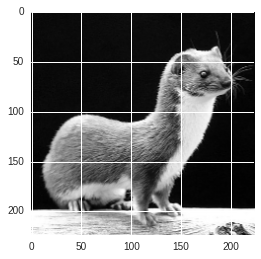

weasel 0.638717
mink 0.206974
polecat, fitch, foulmart, foumart, Mustela putorius 0.123453
black-footed ferret, ferret, Mustela nigripes 0.0296186
otter 0.000799977


In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
img1 = imread('laska.png', mode='RGB')
img1 = imresize(img1, (224, 224))
print img1.shape
img1 = np.mean(img1, axis = 2)
img1 = np.stack([img1]*3, -1)
# plt.hist(img1.flatten())
# plt.show()
plt.imshow(img1/255)
plt.show()
prob = sess.run(vgg.probs, feed_dict={vgg.imgs: [img1]})[0]
# print "regress:  ", sess.run(vgg.regress, feed_dict={vgg.imgs: [img1]})[0]
preds = (np.argsort(prob)[::-1])[0:5]
for p in preds:
    print class_names[p], prob[p]

In [7]:
loss_record = []
accuracy_record = []
naive_accuracy_record = []

In [11]:
val_accuracy_record = []
val_naive_accuracy_record = []

[[ 0.47337291  0.52662712]
 [ 0.47797751  0.52202249]
 [ 0.29950798  0.70049202]
 [ 0.01648436  0.98351556]
 [ 0.71428841  0.28571162]
 [ 0.40739563  0.5926044 ]
 [ 0.49388018  0.50611973]
 [ 0.63134617  0.36865383]
 [ 0.58471316  0.41528684]
 [ 0.39782855  0.60217142]
 [ 0.71195644  0.28804359]
 [ 0.25848123  0.7415188 ]
 [ 0.69385839  0.30614153]
 [ 0.48167503  0.51832491]
 [ 0.03650367  0.96349639]
 [ 0.52688235  0.47311762]
 [ 0.70091224  0.29908776]
 [ 0.25247088  0.74752909]
 [ 0.50008273  0.49991727]
 [ 0.35067382  0.64932626]
 [ 0.86430722  0.13569276]
 [ 0.31328487  0.68671513]
 [ 0.04182676  0.95817322]
 [ 0.52193773  0.4780623 ]
 [ 0.31199682  0.68800318]
 [ 0.7789737   0.22102633]
 [ 0.15492678  0.84507328]
 [ 0.6800316   0.31996837]
 [ 0.42891678  0.57108319]
 [ 0.82551843  0.17448157]
 [ 0.27449629  0.72550374]
 [ 0.73849601  0.26150399]]


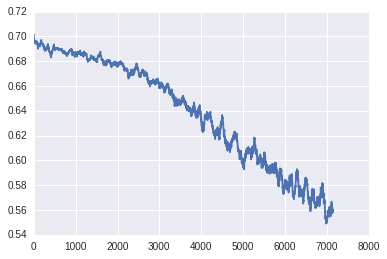

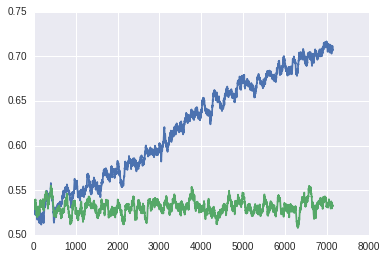

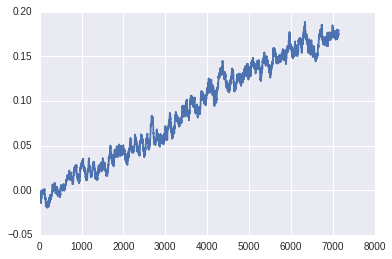

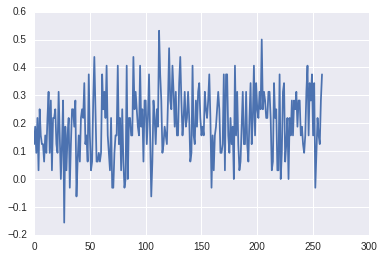

KeyboardInterrupt: 

In [15]:
from IPython.display import clear_output
import seaborn as sns
    
def smooth(x, n=75):
    return np.convolve(np.ones(n, dtype = np.float32) / n, x)[n:-n]
prob_val = 1234
for _ in range(10000):
    
    for i in range(10):
        X, wind, _, Y = get_batch(64)   
#         print wind
        loss_val, accuracy_val, _, prob_val = sess.run([loss, accuracy, optimizer, pred_probabilities], 
                                   feed_dict={vgg.imgs: X, labels: Y, wind_ph: wind, learning_rate_ph:.0001})
        loss_record.append(loss_val)
        accuracy_record.append(accuracy_val)
        naive_accuracy_record.append(np.mean(Y[:,0]))
#         print test
    X, wind, _, Y = get_batch(32, val = True)   
    loss_val, accuracy_val, prob_val = sess.run([loss, accuracy, pred_probabilities], 
                                   feed_dict={vgg.imgs: X, labels: Y, wind_ph: wind, learning_rate_ph:.0001})
    val_accuracy_record.append(accuracy_val)
    val_naive_accuracy_record.append(np.mean(Y[:,0]))
    
    
    
    clear_output()
    print prob_val
    plt.plot(smooth(loss_record))
    plt.show()
    plt.plot(smooth(accuracy_record))
    plt.plot(smooth(naive_accuracy_record))
    plt.show()
    
    plt.plot(smooth(accuracy_record) - smooth(naive_accuracy_record))
    plt.show()
    
    plt.plot(smooth(val_accuracy_record, n=1) - smooth(val_naive_accuracy_record, n=1))
    plt.show()


In [ ]:
X, wind, _, Y = get_batch(32)   
plt.imshow(X[0]/255)
plt.show()

filt_w = vgg.bottom_conv.eval(sess)
for i in range(64):
    plt.imshow(filt_w[0,:,:,i], interpolation = 'nearest', cmap = 'viridis')
    plt.show()
    

In [ ]:
housewise_max_speed = np.amax(wind_data, axis = 1)
# plt.hist(housewise_max_speed)
# plt.show()

# plt.hist(housewise_max_speed[y_data['y'] == 1])
# plt.show()

# plt.hist(housewise_max_speed[y_data['y'] == 0])
# plt.show()
print np.mean(y_data['y'])
n = 1000
p_damage = []
sizes = []
for i in range(int(.6 * n), n):
    low = (1.0 * i/n)
    high = ((1.0 * i+1)/n)
    p_damage.append(np.mean(y_data['y'][np.less(housewise_max_speed, high) * np.greater(housewise_max_speed, low) == 1]))
    sizes.append(np.sum(np.less(housewise_max_speed, high) * np.greater(housewise_max_speed, low)))
plt.plot(p_damage)
plt.show()

plt.plot(sizes)
plt.show()

In [ ]:
print hcad.shape